# exp009 エラー詳細分析

## 分析目的
1. **低価格帯(~500万)のエラー原因分析** - サンプル数2,573件、MAPE 34.78%
2. **大エラーサンプル(APE>30%)の特徴分析** - 全体の約8%

## 分析切り口
- 物件タイプ別、築年数別、エリア別、面積別、アクセス別、地価公示距離別

## 1. セットアップ

In [1]:
import sys
from pathlib import Path

import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib

# パス設定（絶対パスで確実に指定）
project_root = Path("/Users/kotaro/Desktop/ML/20251122_signamte_mlit")
exp_dir = project_root / "06_experiments/exp009_landprice"
output_dir = exp_dir / "outputs"
data_dir = project_root / "data"

# 日本語フォント設定
plt.rcParams['font.family'] = 'IPAexGothic'
plt.rcParams['axes.unicode_minus'] = False

print(f"プロジェクトルート: {project_root}")
print(f"実験ディレクトリ: {exp_dir}")
print(f"データディレクトリ: {data_dir}")
print(f"データ存在確認: {(data_dir / 'raw/train.csv').exists()}")

プロジェクトルート: /Users/kotaro/Desktop/ML/20251122_signamte_mlit
実験ディレクトリ: /Users/kotaro/Desktop/ML/20251122_signamte_mlit/06_experiments/exp009_landprice
データディレクトリ: /Users/kotaro/Desktop/ML/20251122_signamte_mlit/data
データ存在確認: True


In [2]:
# データ読み込み
train_raw = pl.read_csv(data_dir / 'raw/train.csv', infer_schema_length=50000)
print(f"訓練データ: {len(train_raw):,}件")

# OOF予測読み込み
oof_files = list(output_dir.glob("oof_predictions_*.csv"))
oof_df = pl.read_csv(sorted(oof_files)[-1])
print(f"OOF予測: {len(oof_df):,}件")

# エラー計算
oof_df = oof_df.with_columns([
    (pl.col("predicted") - pl.col("actual")).alias("error"),
    ((pl.col("predicted") - pl.col("actual")).abs() / pl.col("actual") * 100).alias("ape"),
    ((pl.col("predicted") - pl.col("actual")) / pl.col("actual") * 100).alias("pe"),  # 符号付き
])

# 訓練データとOOF予測を結合
train_raw = train_raw.with_row_index("id")
df = train_raw.join(oof_df, on="id", how="inner")
print(f"結合データ: {len(df):,}件")

訓練データ: 363,924件
OOF予測: 363,924件


結合データ: 363,924件


In [3]:
# 価格帯・エラー帯の定義
price_bins = [5_000_000, 10_000_000, 20_000_000, 50_000_000]
price_labels = ['~500万', '500-1000万', '1000-2000万', '2000-5000万', '5000万~']

df = df.with_columns([
    pl.col("actual").cut(price_bins, labels=price_labels).alias("price_bin"),
    (pl.col("ape") > 30).alias("large_error"),
    pl.when(pl.col("pe") > 0).then(pl.lit("過大予測")).otherwise(pl.lit("過小予測")).alias("error_direction"),
])

# 築年数計算（snapshot_create_date基準）
# year_built: YYYYMM形式 (例: 199403 = 1994年3月)
# snapshot_create_date: 'YYYY-MM-DD HH:MM:SS'形式
df = df.with_columns([
    # snapshot_create_dateから年を抽出
    pl.col("snapshot_create_date").str.slice(0, 4).cast(pl.Int64).alias("snapshot_year"),
    # year_builtから年を抽出
    (pl.col("year_built") // 100).alias("built_year"),
])

df = df.with_columns([
    (pl.col("snapshot_year") - pl.col("built_year")).alias("building_age"),
])

# 徒歩時間計算（距離/80m）
df = df.with_columns([
    (pl.col("walk_distance1") / 80).ceil().cast(pl.Int64).alias("walk_time1"),
])

print("価格帯別件数:")
print(df.group_by("price_bin").len().sort("price_bin"))

print("\n築年数の確認:")
print(f"  snapshot_year例: {df['snapshot_year'].head(5).to_list()}")
print(f"  built_year例: {df['built_year'].head(5).to_list()}")
print(f"  築年数例: {df['building_age'].head(5).to_list()}")
print(f"  築年数統計: min={df['building_age'].min()}, max={df['building_age'].max()}, mean={df['building_age'].mean():.1f}")

価格帯別件数:
shape: (5, 2)
┌─────────────┬────────┐
│ price_bin   ┆ len    │
│ ---         ┆ ---    │
│ cat         ┆ u32    │
╞═════════════╪════════╡
│ 1000-2000万 ┆ 120082 │
│ 2000-5000万 ┆ 168548 │
│ 500-1000万  ┆ 46734  │
│ 5000万~     ┆ 25987  │
│ ~500万      ┆ 2573   │
└─────────────┴────────┘

築年数の確認:
  snapshot_year例: [2018, 2018, 2018, 2018, 2018]
  built_year例: [1992, 1981, 1995, 2002, 2007]
  築年数例: [26, 37, 23, 16, 11]
  築年数統計: min=-14, max=520, mean=26.5


## 2. 低価格帯(~500万)の詳細分析

In [4]:
# 低価格帯のデータ抽出
low_price = df.filter(pl.col("price_bin") == "~500万")
other_price = df.filter(pl.col("price_bin") != "~500万")

print(f"低価格帯: {len(low_price):,}件 (全体の{len(low_price)/len(df)*100:.1f}%)")
print(f"その他: {len(other_price):,}件")
print(f"\n低価格帯のMAPE: {low_price['ape'].mean():.2f}%")
print(f"その他のMAPE: {other_price['ape'].mean():.2f}%")

低価格帯: 2,573件 (全体の0.7%)
その他: 361,351件

低価格帯のMAPE: 34.78%
その他のMAPE: 12.32%


In [5]:
# 低価格帯 vs その他: 予測方向の比較
print("=== 予測方向の比較 ===")
print("\n【低価格帯】")
low_direction = low_price.group_by("error_direction").agg([
    pl.len().alias("件数"),
    pl.col("ape").mean().alias("MAPE"),
])
print(low_direction)

print("\n【その他】")
other_direction = other_price.group_by("error_direction").agg([
    pl.len().alias("件数"),
    pl.col("ape").mean().alias("MAPE"),
])
print(other_direction)

=== 予測方向の比較 ===

【低価格帯】
shape: (2, 3)
┌─────────────────┬──────┬───────────┐
│ error_direction ┆ 件数 ┆ MAPE      │
│ ---             ┆ ---  ┆ ---       │
│ str             ┆ u32  ┆ f64       │
╞═════════════════╪══════╪═══════════╡
│ 過大予測        ┆ 2376 ┆ 37.494803 │
│ 過小予測        ┆ 197  ┆ 2.068353  │
└─────────────────┴──────┴───────────┘

【その他】
shape: (2, 3)
┌─────────────────┬────────┬───────────┐
│ error_direction ┆ 件数   ┆ MAPE      │
│ ---             ┆ ---    ┆ ---       │
│ str             ┆ u32    ┆ f64       │
╞═════════════════╪════════╪═══════════╡
│ 過小予測        ┆ 185422 ┆ 10.568194 │
│ 過大予測        ┆ 175929 ┆ 14.166453 │
└─────────────────┴────────┴───────────┘


### 2.1 物件タイプ別分析

In [6]:
# 物件タイプの分布比較
def compare_distribution(col_name, display_name, df_low, df_other):
    """低価格帯 vs その他の分布比較"""
    low_dist = df_low.group_by(col_name).agg([
        pl.len().alias("件数"),
        pl.col("ape").mean().alias("MAPE"),
    ]).with_columns(
        (pl.col("件数") / pl.col("件数").sum() * 100).alias("割合(%)")
    ).sort("件数", descending=True)
    
    other_dist = df_other.group_by(col_name).agg([
        pl.len().alias("件数"),
        pl.col("ape").mean().alias("MAPE"),
    ]).with_columns(
        (pl.col("件数") / pl.col("件数").sum() * 100).alias("割合(%)")
    ).sort("件数", descending=True)
    
    print(f"=== {display_name}別分析 ===")
    print(f"\n【低価格帯】Top10")
    print(low_dist.head(10))
    print(f"\n【その他】Top10")
    print(other_dist.head(10))
    
    return low_dist, other_dist

# 物件タイプ
low_bukken, other_bukken = compare_distribution("bukken_type", "物件タイプ", low_price, other_price)

=== 物件タイプ別分析 ===

【低価格帯】Top10
shape: (2, 4)
┌─────────────┬──────┬───────────┬───────────┐
│ bukken_type ┆ 件数 ┆ MAPE      ┆ 割合(%)   │
│ ---         ┆ ---  ┆ ---       ┆ ---       │
│ i64         ┆ u32  ┆ f64       ┆ f64       │
╞═════════════╪══════╪═══════════╪═══════════╡
│ 1202        ┆ 1541 ┆ 39.57806  ┆ 59.891178 │
│ 1302        ┆ 1032 ┆ 27.621441 ┆ 40.108822 │
└─────────────┴──────┴───────────┴───────────┘

【その他】Top10
shape: (2, 4)
┌─────────────┬────────┬───────────┬───────────┐
│ bukken_type ┆ 件数   ┆ MAPE      ┆ 割合(%)   │
│ ---         ┆ ---    ┆ ---       ┆ ---       │
│ i64         ┆ u32    ┆ f64       ┆ f64       │
╞═════════════╪════════╪═══════════╪═══════════╡
│ 1302        ┆ 197582 ┆ 10.88182  ┆ 54.678692 │
│ 1202        ┆ 163769 ┆ 14.055247 ┆ 45.321308 │
└─────────────┴────────┴───────────┴───────────┘


### 2.2 築年数別分析

In [7]:
# 築年数カテゴリ作成
age_bins = [5, 10, 20, 30, 40]
age_labels = ['~5年', '5-10年', '10-20年', '20-30年', '30-40年', '40年~']

df = df.with_columns([
    pl.col("building_age").cut(age_bins, labels=age_labels).alias("age_bin")
])
low_price = df.filter(pl.col("price_bin") == "~500万")
other_price = df.filter(pl.col("price_bin") != "~500万")

low_age, other_age = compare_distribution("age_bin", "築年数", low_price, other_price)

=== 築年数別分析 ===

【低価格帯】Top10
shape: (6, 4)
┌─────────┬──────┬───────────┬───────────┐
│ age_bin ┆ 件数 ┆ MAPE      ┆ 割合(%)   │
│ ---     ┆ ---  ┆ ---       ┆ ---       │
│ cat     ┆ u32  ┆ f64       ┆ f64       │
╞═════════╪══════╪═══════════╪═══════════╡
│ 40年~   ┆ 1247 ┆ 32.540503 ┆ 48.464827 │
│ 30-40年 ┆ 732  ┆ 32.726012 ┆ 28.449281 │
│ 20-30年 ┆ 430  ┆ 34.103367 ┆ 16.712009 │
│ null    ┆ 103  ┆ 61.154941 ┆ 4.003109  │
│ 10-20年 ┆ 33   ┆ 50.875749 ┆ 1.28255   │
│ ~5年    ┆ 28   ┆ 82.834407 ┆ 1.088224  │
└─────────┴──────┴───────────┴───────────┘

【その他】Top10
shape: (7, 4)
┌─────────┬───────┬───────────┬───────────┐
│ age_bin ┆ 件数  ┆ MAPE      ┆ 割合(%)   │
│ ---     ┆ ---   ┆ ---       ┆ ---       │
│ cat     ┆ u32   ┆ f64       ┆ f64       │
╞═════════╪═══════╪═══════════╪═══════════╡
│ 20-30年 ┆ 89482 ┆ 12.46118  ┆ 24.76318  │
│ 30-40年 ┆ 74400 ┆ 13.310263 ┆ 20.589399 │
│ 10-20年 ┆ 69232 ┆ 9.898728  ┆ 19.159211 │
│ 40年~   ┆ 61727 ┆ 14.567897 ┆ 17.082283 │
│ ~5年    ┆ 27294 ┆ 10.200679 ┆ 7.5533

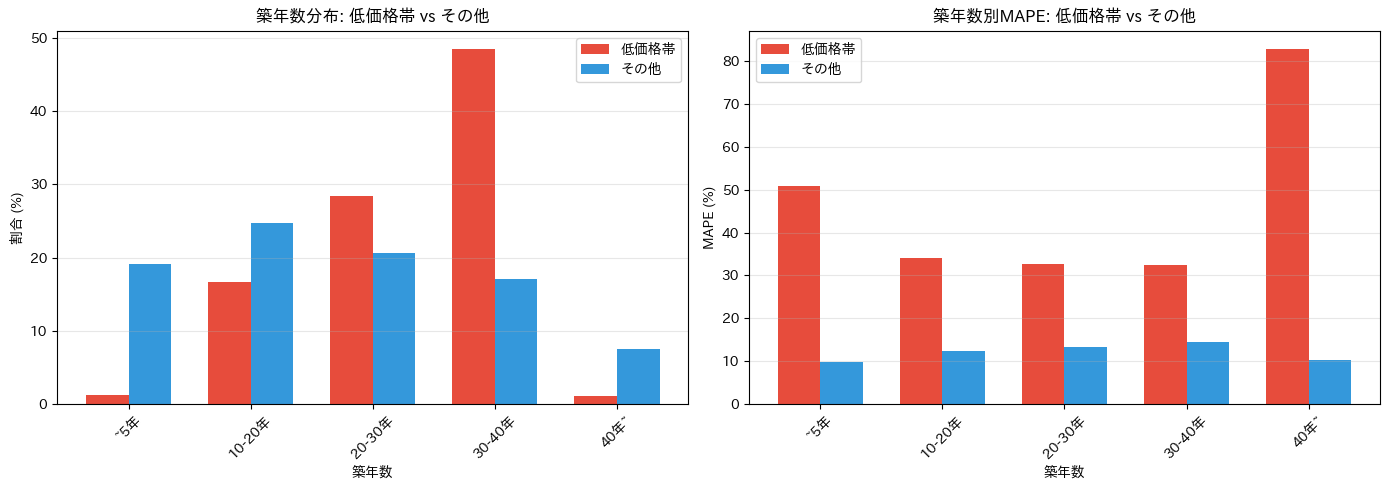

In [8]:
# 築年数分布の可視化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 両方のデータに存在するカテゴリのみ使用
common_age_bins = set(low_age["age_bin"].to_list()) & set(other_age["age_bin"].to_list())
age_labels_filtered = [a for a in age_labels if a in common_age_bins]

# フィルタリングしてソート
low_age_filtered = low_age.filter(pl.col("age_bin").is_in(age_labels_filtered)).sort("age_bin")
other_age_filtered = other_age.filter(pl.col("age_bin").is_in(age_labels_filtered)).sort("age_bin")

# 分布比較
ax = axes[0]
x = np.arange(len(age_labels_filtered))
width = 0.35

ax.bar(x - width/2, low_age_filtered["割合(%)"].to_numpy(), width, label='低価格帯', color='#E74C3C')
ax.bar(x + width/2, other_age_filtered["割合(%)"].to_numpy(), width, label='その他', color='#3498DB')
ax.set_xticks(x)
ax.set_xticklabels(age_labels_filtered, rotation=45)
ax.set_xlabel("築年数")
ax.set_ylabel("割合 (%)")
ax.set_title("築年数分布: 低価格帯 vs その他")
ax.legend()
ax.grid(axis='y', alpha=0.3)

# MAPE比較
ax = axes[1]
ax.bar(x - width/2, low_age_filtered["MAPE"].to_numpy(), width, label='低価格帯', color='#E74C3C')
ax.bar(x + width/2, other_age_filtered["MAPE"].to_numpy(), width, label='その他', color='#3498DB')
ax.set_xticks(x)
ax.set_xticklabels(age_labels_filtered, rotation=45)
ax.set_xlabel("築年数")
ax.set_ylabel("MAPE (%)")
ax.set_title("築年数別MAPE: 低価格帯 vs その他")
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / "low_price_age_analysis.png", dpi=150, bbox_inches='tight')
plt.show()

### 2.3 エリア別分析

In [9]:
# 都道府県別分析
low_pref, other_pref = compare_distribution("addr1_1", "都道府県", low_price, other_price)

=== 都道府県別分析 ===

【低価格帯】Top10
shape: (10, 4)
┌─────────┬──────┬───────────┬───────────┐
│ addr1_1 ┆ 件数 ┆ MAPE      ┆ 割合(%)   │
│ ---     ┆ ---  ┆ ---       ┆ ---       │
│ i64     ┆ u32  ┆ f64       ┆ f64       │
╞═════════╪══════╪═══════════╪═══════════╡
│ 27      ┆ 304  ┆ 32.204038 ┆ 11.815002 │
│ 28      ┆ 260  ┆ 37.35494  ┆ 10.104936 │
│ 40      ┆ 215  ┆ 29.420344 ┆ 8.356005  │
│ 12      ┆ 201  ┆ 32.851637 ┆ 7.811893  │
│ 11      ┆ 162  ┆ 34.569983 ┆ 6.296152  │
│ 14      ┆ 142  ┆ 36.74624  ┆ 5.51885   │
│ 22      ┆ 103  ┆ 50.944143 ┆ 4.003109  │
│ 26      ┆ 94   ┆ 26.930539 ┆ 3.653323  │
│ 8       ┆ 94   ┆ 29.033668 ┆ 3.653323  │
│ 23      ┆ 88   ┆ 45.917895 ┆ 3.420132  │
└─────────┴──────┴───────────┴───────────┘

【その他】Top10
shape: (10, 4)
┌─────────┬───────┬───────────┬───────────┐
│ addr1_1 ┆ 件数  ┆ MAPE      ┆ 割合(%)   │
│ ---     ┆ ---   ┆ ---       ┆ ---       │
│ i64     ┆ u32   ┆ f64       ┆ f64       │
╞═════════╪═══════╪═══════════╪═══════════╡
│ 13      ┆ 66365 ┆ 10.201617

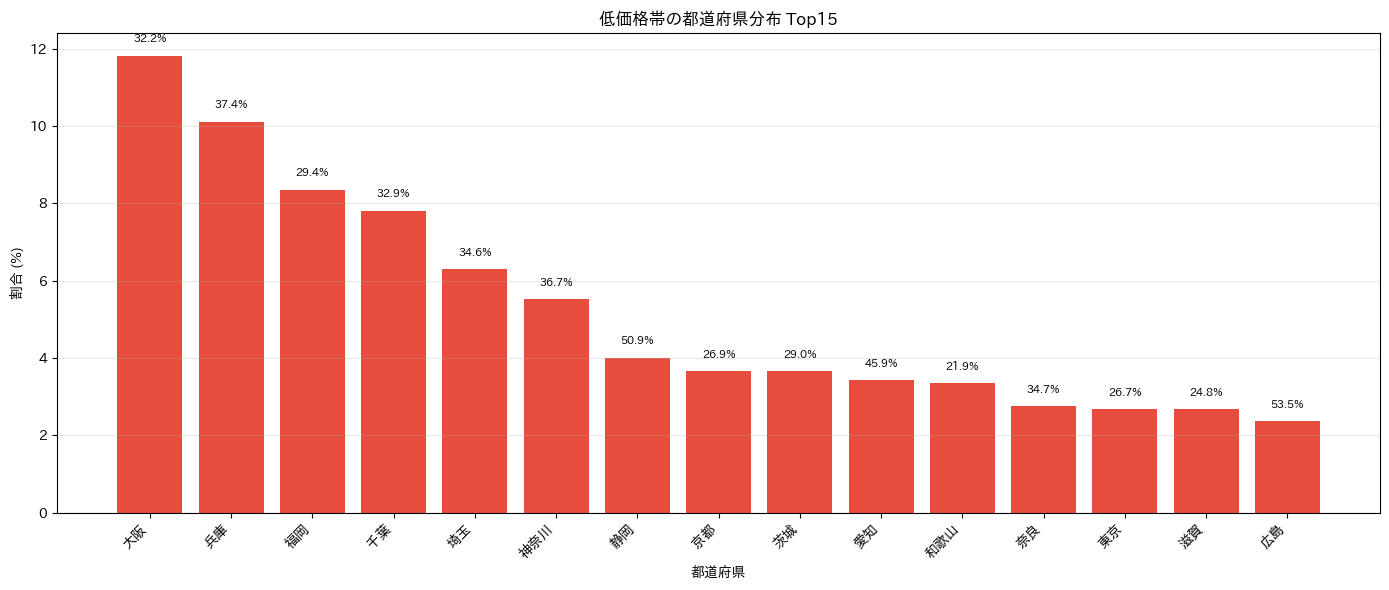

In [10]:
# 都道府県コードマッピング（主要都道府県）
pref_map = {
    1: "北海道", 2: "青森", 3: "岩手", 4: "宮城", 5: "秋田", 6: "山形", 7: "福島",
    8: "茨城", 9: "栃木", 10: "群馬", 11: "埼玉", 12: "千葉", 13: "東京", 14: "神奈川",
    15: "新潟", 16: "富山", 17: "石川", 18: "福井", 19: "山梨", 20: "長野",
    21: "岐阜", 22: "静岡", 23: "愛知", 24: "三重", 25: "滋賀", 26: "京都",
    27: "大阪", 28: "兵庫", 29: "奈良", 30: "和歌山", 31: "鳥取", 32: "島根",
    33: "岡山", 34: "広島", 35: "山口", 36: "徳島", 37: "香川", 38: "愛媛", 39: "高知",
    40: "福岡", 41: "佐賀", 42: "長崎", 43: "熊本", 44: "大分", 45: "宮崎", 46: "鹿児島", 47: "沖縄"
}

# 低価格帯の都道府県分布を可視化
fig, ax = plt.subplots(figsize=(14, 6))

low_pref_top = low_pref.head(15)
pref_names = [pref_map.get(int(c), str(c)) for c in low_pref_top["addr1_1"].to_list()]
x = np.arange(len(pref_names))

bars = ax.bar(x, low_pref_top["割合(%)"].to_numpy(), color='#E74C3C')
ax.set_xticks(x)
ax.set_xticklabels(pref_names, rotation=45, ha='right')
ax.set_xlabel("都道府県")
ax.set_ylabel("割合 (%)")
ax.set_title("低価格帯の都道府県分布 Top15")
ax.grid(axis='y', alpha=0.3)

# MAPE値をバーの上に表示
for i, (bar, mape) in enumerate(zip(bars, low_pref_top["MAPE"].to_list())):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
            f'{mape:.1f}%', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig(output_dir / "low_price_pref_distribution.png", dpi=150, bbox_inches='tight')
plt.show()

### 2.4 面積別分析

In [11]:
# 面積カテゴリ作成
area_bins = [20, 30, 50, 70, 100]
area_labels = ['~20m²', '20-30m²', '30-50m²', '50-70m²', '70-100m²', '100m²~']

df = df.with_columns([
    pl.col("unit_area").cut(area_bins, labels=area_labels).alias("area_bin")
])
low_price = df.filter(pl.col("price_bin") == "~500万")
other_price = df.filter(pl.col("price_bin") != "~500万")

low_area, other_area = compare_distribution("area_bin", "専有面積", low_price, other_price)

=== 専有面積別分析 ===

【低価格帯】Top10
shape: (7, 4)
┌──────────┬──────┬───────────┬───────────┐
│ area_bin ┆ 件数 ┆ MAPE      ┆ 割合(%)   │
│ ---      ┆ ---  ┆ ---       ┆ ---       │
│ cat      ┆ u32  ┆ f64       ┆ f64       │
╞══════════╪══════╪═══════════╪═══════════╡
│ 70-100m² ┆ 679  ┆ 36.635337 ┆ 26.389429 │
│ 50-70m²  ┆ 596  ┆ 31.72492  ┆ 23.163622 │
│ 100m²~   ┆ 421  ┆ 51.621496 ┆ 16.362223 │
│ 30-50m²  ┆ 316  ┆ 27.404994 ┆ 12.281384 │
│ null     ┆ 233  ┆ 44.171104 ┆ 9.055577  │
│ ~20m²    ┆ 187  ┆ 14.102891 ┆ 7.267781  │
│ 20-30m²  ┆ 141  ┆ 16.949902 ┆ 5.479984  │
└──────────┴──────┴───────────┴───────────┘

【その他】Top10
shape: (7, 4)
┌──────────┬────────┬───────────┬───────────┐
│ area_bin ┆ 件数   ┆ MAPE      ┆ 割合(%)   │
│ ---      ┆ ---    ┆ ---       ┆ ---       │
│ cat      ┆ u32    ┆ f64       ┆ f64       │
╞══════════╪════════╪═══════════╪═══════════╡
│ 70-100m² ┆ 120908 ┆ 11.809124 ┆ 33.459988 │
│ 100m²~   ┆ 88271  ┆ 13.582671 ┆ 24.428049 │
│ 50-70m²  ┆ 73611  ┆ 11.732457 ┆ 20.371052 │

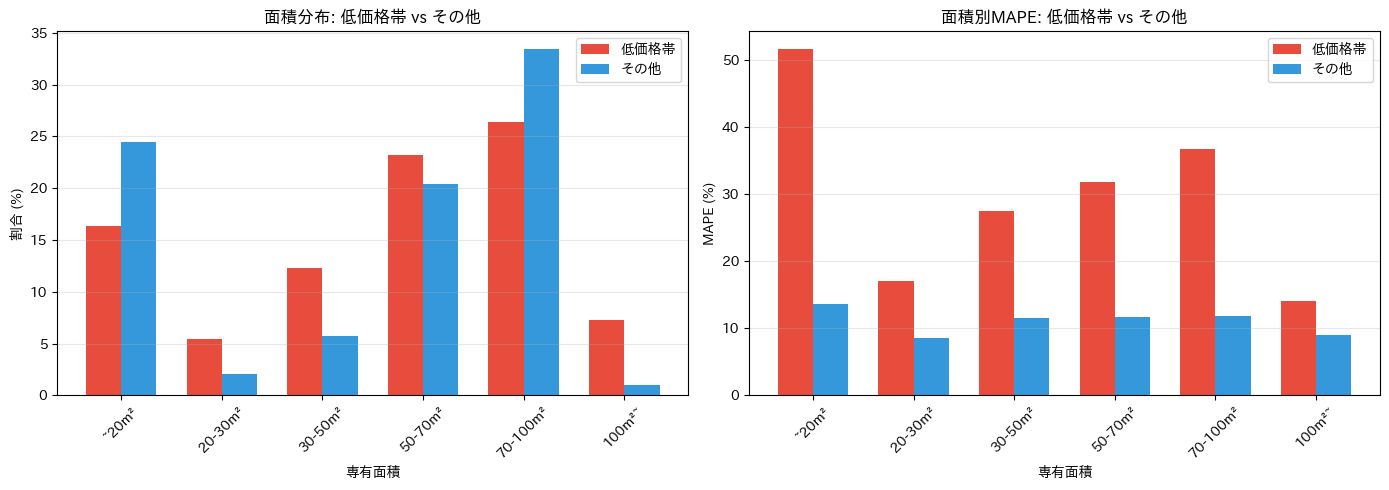

In [12]:
# 面積分布の可視化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 両方のデータに存在するカテゴリのみ使用
common_area_bins = set(low_area["area_bin"].to_list()) & set(other_area["area_bin"].to_list())
area_labels_filtered = [a for a in area_labels if a in common_area_bins]

# フィルタリングしてソート
low_area_filtered = low_area.filter(pl.col("area_bin").is_in(area_labels_filtered)).sort("area_bin")
other_area_filtered = other_area.filter(pl.col("area_bin").is_in(area_labels_filtered)).sort("area_bin")

# 分布比較
ax = axes[0]
x = np.arange(len(area_labels_filtered))
width = 0.35

ax.bar(x - width/2, low_area_filtered["割合(%)"].to_numpy(), width, label='低価格帯', color='#E74C3C')
ax.bar(x + width/2, other_area_filtered["割合(%)"].to_numpy(), width, label='その他', color='#3498DB')
ax.set_xticks(x)
ax.set_xticklabels(area_labels_filtered, rotation=45)
ax.set_xlabel("専有面積")
ax.set_ylabel("割合 (%)")
ax.set_title("面積分布: 低価格帯 vs その他")
ax.legend()
ax.grid(axis='y', alpha=0.3)

# MAPE比較
ax = axes[1]
ax.bar(x - width/2, low_area_filtered["MAPE"].to_numpy(), width, label='低価格帯', color='#E74C3C')
ax.bar(x + width/2, other_area_filtered["MAPE"].to_numpy(), width, label='その他', color='#3498DB')
ax.set_xticks(x)
ax.set_xticklabels(area_labels_filtered, rotation=45)
ax.set_xlabel("専有面積")
ax.set_ylabel("MAPE (%)")
ax.set_title("面積別MAPE: 低価格帯 vs その他")
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / "low_price_area_analysis.png", dpi=150, bbox_inches='tight')
plt.show()

### 2.5 アクセス別分析

In [13]:
# 徒歩時間カテゴリ作成
walk_bins = [5, 10, 15, 20, 30]
walk_labels = ['~5分', '5-10分', '10-15分', '15-20分', '20-30分', '30分~']

df = df.with_columns([
    pl.col("walk_time1").cut(walk_bins, labels=walk_labels).alias("walk_bin")
])
low_price = df.filter(pl.col("price_bin") == "~500万")
other_price = df.filter(pl.col("price_bin") != "~500万")

low_walk, other_walk = compare_distribution("walk_bin", "徒歩時間", low_price, other_price)

=== 徒歩時間別分析 ===

【低価格帯】Top10
shape: (7, 4)
┌──────────┬──────┬───────────┬───────────┐
│ walk_bin ┆ 件数 ┆ MAPE      ┆ 割合(%)   │
│ ---      ┆ ---  ┆ ---       ┆ ---       │
│ cat      ┆ u32  ┆ f64       ┆ f64       │
╞══════════╪══════╪═══════════╪═══════════╡
│ ~5分     ┆ 666  ┆ 34.309024 ┆ 25.884182 │
│ 5-10分   ┆ 533  ┆ 31.843795 ┆ 20.715119 │
│ 10-15分  ┆ 393  ┆ 33.126025 ┆ 15.273999 │
│ 15-20分  ┆ 292  ┆ 34.763247 ┆ 11.34862  │
│ 20-30分  ┆ 290  ┆ 36.790587 ┆ 11.27089  │
│ 30分~    ┆ 272  ┆ 36.384153 ┆ 10.571318 │
│ null     ┆ 127  ┆ 46.751258 ┆ 4.935873  │
└──────────┴──────┴───────────┴───────────┘

【その他】Top10
shape: (7, 4)
┌──────────┬────────┬───────────┬───────────┐
│ walk_bin ┆ 件数   ┆ MAPE      ┆ 割合(%)   │
│ ---      ┆ ---    ┆ ---       ┆ ---       │
│ cat      ┆ u32    ┆ f64       ┆ f64       │
╞══════════╪════════╪═══════════╪═══════════╡
│ ~5分     ┆ 102586 ┆ 11.804051 ┆ 28.389571 │
│ 5-10分   ┆ 99646  ┆ 11.766946 ┆ 27.575958 │
│ 10-15分  ┆ 65989  ┆ 12.51578  ┆ 18.261746 │
│ 15-20分

### 2.6 低価格帯サマリー

In [14]:
# 低価格帯の統計サマリー
print("=" * 60)
print("低価格帯(~500万) 特徴サマリー")
print("=" * 60)

print(f"\n【基本統計】")
print(f"  件数: {len(low_price):,}件 (全体の{len(low_price)/len(df)*100:.2f}%)")
print(f"  平均賃料: {low_price['actual'].mean():,.0f}円")
print(f"  MAPE: {low_price['ape'].mean():.2f}%")
print(f"  Median APE: {low_price['ape'].median():.2f}%")

# 予測方向
over_pred = low_price.filter(pl.col("error_direction") == "過大予測")
under_pred = low_price.filter(pl.col("error_direction") == "過小予測")
print(f"\n【予測方向】")
print(f"  過大予測: {len(over_pred):,}件 ({len(over_pred)/len(low_price)*100:.1f}%) - MAPE {over_pred['ape'].mean():.2f}%")
print(f"  過小予測: {len(under_pred):,}件 ({len(under_pred)/len(low_price)*100:.1f}%) - MAPE {under_pred['ape'].mean():.2f}%")

print(f"\n【築年数】")
print(f"  平均築年数: {low_price['building_age'].mean():.1f}年")
print(f"  築40年以上の割合: {len(low_price.filter(pl.col('building_age') >= 40)) / len(low_price) * 100:.1f}%")

print(f"\n【面積】")
print(f"  平均専有面積: {low_price['unit_area'].mean():.1f}m²")
print(f"  20m²未満の割合: {len(low_price.filter(pl.col('unit_area') < 20)) / len(low_price) * 100:.1f}%")

print("=" * 60)

低価格帯(~500万) 特徴サマリー

【基本統計】
  件数: 2,573件 (全体の0.71%)
  平均賃料: 4,962,566円
  MAPE: 34.78%
  Median APE: 22.21%

【予測方向】
  過大予測: 2,376件 (92.3%) - MAPE 37.49%
  過小予測: 197件 (7.7%) - MAPE 2.07%

【築年数】
  平均築年数: 40.3年
  築40年以上の割合: 52.5%

【面積】
  平均専有面積: 73.3m²
  20m²未満の割合: 7.2%


## 3. 大エラーサンプル(APE>30%)の分析

In [15]:
# 大エラーサンプルの抽出
large_error = df.filter(pl.col("large_error"))
normal_error = df.filter(~pl.col("large_error"))

print(f"大エラー(APE>30%): {len(large_error):,}件 (全体の{len(large_error)/len(df)*100:.1f}%)")
print(f"正常エラー: {len(normal_error):,}件")
print(f"\n大エラーのMAPE: {large_error['ape'].mean():.2f}%")

大エラー(APE>30%): 30,152件 (全体の8.3%)
正常エラー: 333,772件

大エラーのMAPE: 48.64%


In [16]:
# 大エラーの予測方向
print("=== 大エラーの予測方向 ===")
large_error_direction = large_error.group_by("error_direction").agg([
    pl.len().alias("件数"),
    pl.col("ape").mean().alias("MAPE"),
    pl.col("actual").mean().alias("平均実賃料"),
])
print(large_error_direction)

=== 大エラーの予測方向 ===
shape: (2, 4)
┌─────────────────┬───────┬───────────┬────────────┐
│ error_direction ┆ 件数  ┆ MAPE      ┆ 平均実賃料 │
│ ---             ┆ ---   ┆ ---       ┆ ---        │
│ str             ┆ u32   ┆ f64       ┆ f64        │
╞═════════════════╪═══════╪═══════════╪════════════╡
│ 過大予測        ┆ 21455 ┆ 52.874907 ┆ 1.3844e7   │
│ 過小予測        ┆ 8697  ┆ 38.20197  ┆ 3.3586e7   │
└─────────────────┴───────┴───────────┴────────────┘


In [17]:
# 大エラーの価格帯分布
print("=== 大エラーの価格帯分布 ===")
large_error_by_price = large_error.group_by("price_bin").agg([
    pl.len().alias("大エラー件数"),
    pl.col("ape").mean().alias("MAPE"),
]).sort("price_bin")

# 各価格帯の総件数を取得
total_by_price = df.group_by("price_bin").len().sort("price_bin")

# 結合して大エラー率を計算
large_error_rate = large_error_by_price.join(
    total_by_price.rename({"len": "総件数"}), on="price_bin"
).with_columns(
    (pl.col("大エラー件数") / pl.col("総件数") * 100).alias("大エラー率(%)")
)
print(large_error_rate)

=== 大エラーの価格帯分布 ===
shape: (5, 5)
┌─────────────┬──────────────┬───────────┬────────┬───────────────┐
│ price_bin   ┆ 大エラー件数 ┆ MAPE      ┆ 総件数 ┆ 大エラー率(%) │
│ ---         ┆ ---          ┆ ---       ┆ ---    ┆ ---           │
│ cat         ┆ u32          ┆ f64       ┆ u32    ┆ f64           │
╞═════════════╪══════════════╪═══════════╪════════╪═══════════════╡
│ 1000-2000万 ┆ 10786        ┆ 44.827628 ┆ 120082 ┆ 8.982195      │
│ 2000-5000万 ┆ 6956         ┆ 40.421811 ┆ 168548 ┆ 4.127014      │
│ 500-1000万  ┆ 9804         ┆ 57.498361 ┆ 46734  ┆ 20.978303     │
│ 5000万~     ┆ 1577         ┆ 41.374521 ┆ 25987  ┆ 6.068419      │
│ ~500万      ┆ 1029         ┆ 70.969103 ┆ 2573   ┆ 39.992227     │
└─────────────┴──────────────┴───────────┴────────┴───────────────┘


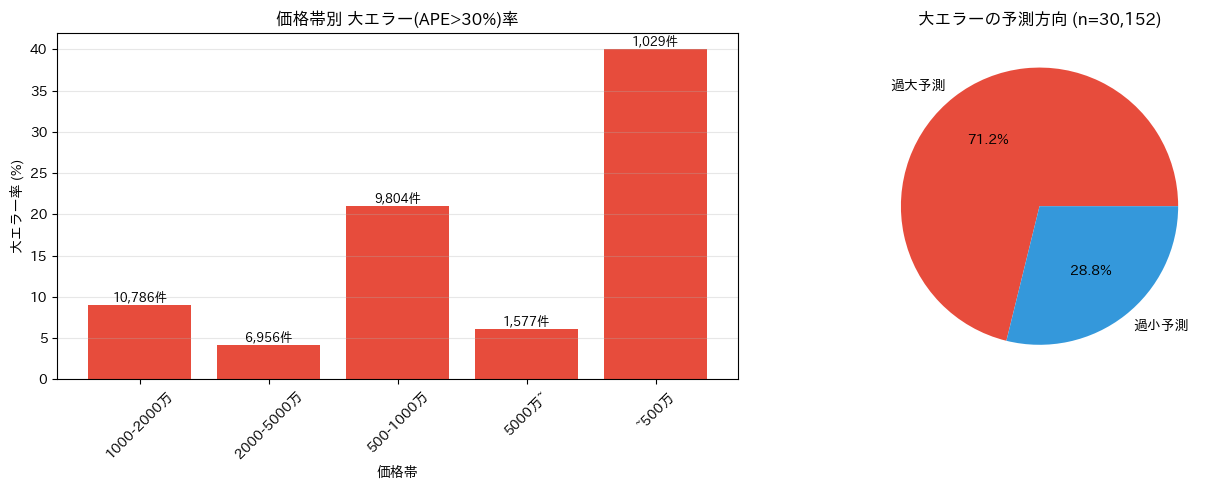

In [18]:
# 大エラー率の可視化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 価格帯別大エラー率
ax = axes[0]
x = np.arange(len(large_error_rate))
ax.bar(x, large_error_rate["大エラー率(%)"].to_numpy(), color='#E74C3C')
ax.set_xticks(x)
ax.set_xticklabels(large_error_rate["price_bin"].to_list(), rotation=45)
ax.set_xlabel("価格帯")
ax.set_ylabel("大エラー率 (%)")
ax.set_title("価格帯別 大エラー(APE>30%)率")
ax.grid(axis='y', alpha=0.3)

# 件数表示
for i, (rate, count) in enumerate(zip(large_error_rate["大エラー率(%)"].to_list(), 
                                       large_error_rate["大エラー件数"].to_list())):
    ax.text(i, rate + 0.5, f'{count:,}件', ha='center', fontsize=9)

# 予測方向別
ax = axes[1]
over = len(large_error.filter(pl.col("error_direction") == "過大予測"))
under = len(large_error.filter(pl.col("error_direction") == "過小予測"))
ax.pie([over, under], labels=['過大予測', '過小予測'], autopct='%1.1f%%', colors=['#E74C3C', '#3498DB'])
ax.set_title(f"大エラーの予測方向 (n={len(large_error):,})")

plt.tight_layout()
plt.savefig(output_dir / "large_error_overview.png", dpi=150, bbox_inches='tight')
plt.show()

### 3.1 大エラーの特徴分析

In [19]:
# 大エラー vs 正常: 特徴量の比較
def compare_stats(col_name, display_name):
    """大エラー vs 正常の統計比較"""
    large_stats = large_error[col_name].describe()
    normal_stats = normal_error[col_name].describe()
    
    print(f"=== {display_name} ===")
    print(f"  大エラー - 平均: {large_error[col_name].mean():.2f}, 中央値: {large_error[col_name].median():.2f}")
    print(f"  正常     - 平均: {normal_error[col_name].mean():.2f}, 中央値: {normal_error[col_name].median():.2f}")
    print()

compare_stats("building_age", "築年数")
compare_stats("unit_area", "専有面積")
compare_stats("walk_time1", "徒歩時間")
compare_stats("actual", "実賃料")

=== 築年数 ===
  大エラー - 平均: 32.05, 中央値: 32.00
  正常     - 平均: 26.07, 中央値: 26.00

=== 専有面積 ===
  大エラー - 平均: 99.36, 中央値: 87.02
  正常     - 平均: 87.14, 中央値: 79.72

=== 徒歩時間 ===
  大エラー - 平均: 14.54, 中央値: 10.00
  正常     - 平均: 12.57, 中央値: 9.00

=== 実賃料 ===
  大エラー - 平均: 19538127.29, 中央値: 13800000.00
  正常     - 平均: 26502061.14, 中央値: 22800000.00



In [20]:
# 大エラーのカテゴリ別分析
print("=== 大エラー: 築年数別 ===")
large_by_age = large_error.group_by("age_bin").agg([
    pl.len().alias("件数"),
]).sort("age_bin")
large_by_age = large_by_age.with_columns(
    (pl.col("件数") / pl.col("件数").sum() * 100).alias("割合(%)")
)
print(large_by_age)

print("\n=== 大エラー: 面積別 ===")
large_by_area = large_error.group_by("area_bin").agg([
    pl.len().alias("件数"),
]).sort("area_bin")
large_by_area = large_by_area.with_columns(
    (pl.col("件数") / pl.col("件数").sum() * 100).alias("割合(%)")
)
print(large_by_area)

=== 大エラー: 築年数別 ===
shape: (7, 3)
┌─────────┬──────┬───────────┐
│ age_bin ┆ 件数 ┆ 割合(%)   │
│ ---     ┆ ---  ┆ ---       │
│ cat     ┆ u32  ┆ f64       │
╞═════════╪══════╪═══════════╡
│ null    ┆ 2677 ┆ 8.87835   │
│ 10-20年 ┆ 2831 ┆ 9.389095  │
│ 20-30年 ┆ 7194 ┆ 23.859114 │
│ 30-40年 ┆ 7372 ┆ 24.449456 │
│ 40年~   ┆ 7798 ┆ 25.862298 │
│ 5-10年  ┆ 713  ┆ 2.364686  │
│ ~5年    ┆ 1567 ┆ 5.197002  │
└─────────┴──────┴───────────┘

=== 大エラー: 面積別 ===
shape: (7, 3)
┌──────────┬──────┬───────────┐
│ area_bin ┆ 件数 ┆ 割合(%)   │
│ ---      ┆ ---  ┆ ---       │
│ cat      ┆ u32  ┆ f64       │
╞══════════╪══════╪═══════════╡
│ null     ┆ 4586 ┆ 15.209605 │
│ 100m²~   ┆ 9242 ┆ 30.651366 │
│ 20-30m²  ┆ 292  ┆ 0.968427  │
│ 30-50m²  ┆ 1522 ┆ 5.047758  │
│ 50-70m²  ┆ 5371 ┆ 17.81308  │
│ 70-100m² ┆ 8998 ┆ 29.842133 │
│ ~20m²    ┆ 141  ┆ 0.467631  │
└──────────┴──────┴───────────┘


In [21]:
# 大エラーの都道府県分布
print("=== 大エラー: 都道府県別(大エラー率順) ===")
large_by_pref = large_error.group_by("addr1_1").len().rename({"len": "大エラー件数"})
total_by_pref = df.group_by("addr1_1").len().rename({"len": "総件数"})

pref_error_rate = large_by_pref.join(total_by_pref, on="addr1_1").with_columns(
    (pl.col("大エラー件数") / pl.col("総件数") * 100).alias("大エラー率(%)")
).filter(pl.col("総件数") >= 100).sort("大エラー率(%)", descending=True)

# 都道府県名を追加
pref_error_rate = pref_error_rate.with_columns(
    pl.col("addr1_1").map_elements(lambda x: pref_map.get(int(x), str(x)), return_dtype=pl.Utf8).alias("都道府県名")
)
print(pref_error_rate.head(15))

=== 大エラー: 都道府県別(大エラー率順) ===
shape: (15, 5)
┌─────────┬──────────────┬────────┬───────────────┬────────────┐
│ addr1_1 ┆ 大エラー件数 ┆ 総件数 ┆ 大エラー率(%) ┆ 都道府県名 │
│ ---     ┆ ---          ┆ ---    ┆ ---           ┆ ---        │
│ i64     ┆ u32          ┆ u32    ┆ f64           ┆ str        │
╞═════════╪══════════════╪════════╪═══════════════╪════════════╡
│ 42      ┆ 102          ┆ 778    ┆ 13.11054      ┆ 長崎       │
│ 39      ┆ 187          ┆ 1457   ┆ 12.834592     ┆ 高知       │
│ 29      ┆ 482          ┆ 3759   ┆ 12.822559     ┆ 奈良       │
│ 35      ┆ 309          ┆ 2451   ┆ 12.607099     ┆ 山口       │
│ 24      ┆ 137          ┆ 1122   ┆ 12.210339     ┆ 三重       │
│ …       ┆ …            ┆ …      ┆ …             ┆ …          │
│ 26      ┆ 1486         ┆ 13018  ┆ 11.414964     ┆ 京都       │
│ 5       ┆ 39           ┆ 347    ┆ 11.239193     ┆ 秋田       │
│ 28      ┆ 2528         ┆ 22778  ┆ 11.098428     ┆ 兵庫       │
│ 19      ┆ 43           ┆ 389    ┆ 11.053985     ┆ 山梨       │
│ 25      ┆ 577    

### 3.2 リフォーム有無による分析

In [22]:
# リフォーム有無のフラグ作成
df = df.with_columns([
    (pl.col("reform_wet_area").is_not_null() | pl.col("reform_interior").is_not_null()).alias("has_reform")
])

# リフォーム有無別のエラー分析
reform_analysis = df.group_by("has_reform").agg([
    pl.len().alias("件数"),
    pl.col("ape").mean().alias("MAPE"),
    pl.col("large_error").sum().alias("大エラー件数"),
]).with_columns(
    (pl.col("大エラー件数") / pl.col("件数") * 100).alias("大エラー率(%)")
)

print("=== リフォーム有無別 ===")
print(reform_analysis)

=== リフォーム有無別 ===
shape: (2, 5)
┌────────────┬────────┬───────────┬──────────────┬───────────────┐
│ has_reform ┆ 件数   ┆ MAPE      ┆ 大エラー件数 ┆ 大エラー率(%) │
│ ---        ┆ ---    ┆ ---       ┆ ---          ┆ ---           │
│ bool       ┆ u32    ┆ f64       ┆ u32          ┆ f64           │
╞════════════╪════════╪═══════════╪══════════════╪═══════════════╡
│ true       ┆ 91694  ┆ 11.323636 ┆ 5304         ┆ 5.784457      │
│ false      ┆ 272230 ┆ 12.867983 ┆ 24848        ┆ 9.127576      │
└────────────┴────────┴───────────┴──────────────┴───────────────┘


## 4. 分析サマリーと改善提案

In [23]:
print("""
============================================================
エラー詳細分析サマリー
============================================================

【1. 低価格帯(~500万)の特徴】
""")

print(f"  - 件数: {len(low_price):,}件 (全体の{len(low_price)/len(df)*100:.2f}%)")
print(f"  - MAPE: {low_price['ape'].mean():.2f}% (全体平均の約2.8倍)")
print(f"  - 過大予測が多い: {len(over_pred)/len(low_price)*100:.1f}%")
print(f"  - 築古物件が多い: 平均築年数 {low_price['building_age'].mean():.1f}年")

print("""
【2. 大エラー(APE>30%)の特徴】
""")
print(f"  - 件数: {len(large_error):,}件 (全体の{len(large_error)/len(df)*100:.1f}%)")
print(f"  - 低価格帯に集中: ~500万で{len(large_error.filter(pl.col('price_bin')=='~500万'))/len(large_error)*100:.1f}%")
over_large = len(large_error.filter(pl.col("error_direction") == "過大予測"))
print(f"  - 過大予測が優勢: {over_large/len(large_error)*100:.1f}%")

print("""
============================================================
改善提案
============================================================

【特徴量追加】
1. 築年数×価格帯の交互作用特徴量
   - 築古×低価格帯の組み合わせを捕捉

2. エリア粒度の細分化
   - 市区町村レベルの地価情報追加
   - 最寄駅の乗降客数データ

3. 低価格帯特有の特徴量
   - 投資用物件フラグ(flg_investment)の活用
   - 空室率関連情報

【モデリング改善】
1. サンプル重み付け
   - 低価格帯のサンプルに高い重みを付与
   - sample_weight = 1 / (price_bin_count / total_count)

2. 価格帯別モデル
   - 低価格帯専用のサブモデルを学習
   - スタッキングで統合

3. 外れ値処理
   - APE>100%のサンプルを除外または重み低下
   - 極端な予測値のクリッピング

【目標】
- 低価格帯MAPE: 34.78% → 25%以下
- 大エラー率: 8.4% → 5%以下
============================================================
""")


エラー詳細分析サマリー

【1. 低価格帯(~500万)の特徴】

  - 件数: 2,573件 (全体の0.71%)
  - MAPE: 34.78% (全体平均の約2.8倍)
  - 過大予測が多い: 92.3%
  - 築古物件が多い: 平均築年数 40.3年

【2. 大エラー(APE>30%)の特徴】

  - 件数: 30,152件 (全体の8.3%)
  - 低価格帯に集中: ~500万で3.4%
  - 過大予測が優勢: 71.2%

改善提案

【特徴量追加】
1. 築年数×価格帯の交互作用特徴量
   - 築古×低価格帯の組み合わせを捕捉

2. エリア粒度の細分化
   - 市区町村レベルの地価情報追加
   - 最寄駅の乗降客数データ

3. 低価格帯特有の特徴量
   - 投資用物件フラグ(flg_investment)の活用
   - 空室率関連情報

【モデリング改善】
1. サンプル重み付け
   - 低価格帯のサンプルに高い重みを付与
   - sample_weight = 1 / (price_bin_count / total_count)

2. 価格帯別モデル
   - 低価格帯専用のサブモデルを学習
   - スタッキングで統合

3. 外れ値処理
   - APE>100%のサンプルを除外または重み低下
   - 極端な予測値のクリッピング

【目標】
- 低価格帯MAPE: 34.78% → 25%以下
- 大エラー率: 8.4% → 5%以下



In [24]:
# 生成した図の一覧
print("\n生成した図:")
for f in sorted(output_dir.glob("*.png")):
    print(f"  - {f.name}")


生成した図:
  - ape_distribution.png
  - category_importance.png
  - error_analysis.png
  - exp008_vs_exp009.png
  - feature_importance_top30.png
  - landprice_feature_importance.png
  - landprice_importance.png
  - large_error_overview.png
  - low_price_age_analysis.png
  - low_price_area_analysis.png
  - low_price_pref_distribution.png
  - prediction_vs_actual.png
  - top30_importance.png
